In [1]:
import pandas as pd 
df = pd.read_csv("merge_all_factor_427.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 97 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Prolific.ID                         427 non-null    object 
 1   pos_state_anxiety_congeneric        427 non-null    float64
 2   neg_state_anxiety_congeneric        427 non-null    float64
 3   pos_trait_anxiety_congeneric        427 non-null    float64
 4   neg_trait_anxiety_congeneric        427 non-null    float64
 5   pos_state_anxiety_parallel          427 non-null    float64
 6   neg_state_anxiety_parallel          427 non-null    float64
 7   pos_trait_anxiety_parallel          427 non-null    float64
 8   neg_trait_anxiety_parallel          427 non-null    float64
 9   state_anxiety_congeneric            427 non-null    float64
 10  trait_anxiety_congeneric            427 non-null    float64
 11  state_anxiety_parallel              427 non-n

In [2]:
# Eksik değer oranlarını görmek
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0].head(20)  # sadece boş olanlardan ilk 20

# Benzersiz değer sayısı -gereksiz ID vb. bulmak için
unique_counts = df.nunique().sort_values(ascending=True).head(20)

# Tiplere göre sütun dağılımı
df.dtypes.value_counts()


float64    48
int64      48
object      1
Name: count, dtype: int64

In [3]:
from collections import defaultdict

groups = defaultdict(list)
for col in df.columns:
    prefix = col.split("_")[0]
    groups[prefix].append(col)

for key, cols in groups.items():
    print(f"{key:10} → {len(cols)} sütun → {cols[:3]}")


Prolific.ID → 1 sütun → ['Prolific.ID']
pos        → 8 sütun → ['pos_state_anxiety_congeneric', 'pos_trait_anxiety_congeneric', 'pos_state_anxiety_parallel']
neg        → 8 sütun → ['neg_state_anxiety_congeneric', 'neg_trait_anxiety_congeneric', 'neg_state_anxiety_parallel']
state      → 4 sütun → ['state_anxiety_congeneric', 'state_anxiety_parallel', 'state_anxiety_med_congeneric']
trait      → 4 sütun → ['trait_anxiety_congeneric', 'trait_anxiety_parallel', 'trait_anxiety_med_congeneric']
anxiety    → 4 sütun → ['anxiety_congeneric_score', 'anxiety_parallel_score', 'anxiety_med_congeneric']
scale      → 16 sütun → ['scale_sum_anxiety', 'scale_sum_state_anxiety', 'scale_sum_trait_anxiety']
sum        → 16 sütun → ['sum_z_score_anxiety', 'sum_z_score_state_anxiety', 'sum_z_score_trait_anxiety']
cog        → 4 sütun → ['cog_affect_congeneric', 'cog_affect_parallel', 'cog_affect_med_congeneric']
somatic    → 4 sütun → ['somatic_congeneric', 'somatic_parallel', 'somatic_med_congeneric']
d

In [6]:
#df içinden gereken sütunları seçmek 
#Makaledeki teorik çerçeveye göre öğrenme kapasitesi; stres, kontrol hissi, öz yeterlilik, depresyon, somatik ve bilişsel-duygusal etkilerden türetilir.
#Bu değişkenlerin normalize edilmiş congeneric skorları modelin feature setini oluşturur.
selected_columns = [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric",
    "covid_congeneric_score"
]

df_reduced = df[selected_columns].copy()
df_reduced.head()



,stress_congeneric_score,control_congeneric,self_efficacy_congeneric,depression_congeneric_score,somatic_congeneric,cog_affect_congeneric,covid_congeneric_score
0,-0.994499,-0.568381,-1.568341,-0.852725,-1.522905,-0.294627,-0.650693
1,-1.601830,-1.258011,-1.846971,-1.430514,-1.403349,-1.390766,-2.270687
2,0.183967,0.516081,-0.397377,-0.347319,0.019725,-0.594503,1.023725
3,0.419527,0.581236,0.063644,-0.825759,-1.003940,-0.594503,0.952817
4,-1.093718,-1.413048,-0.214986,0.870991,1.372580,0.501635,-1.402679


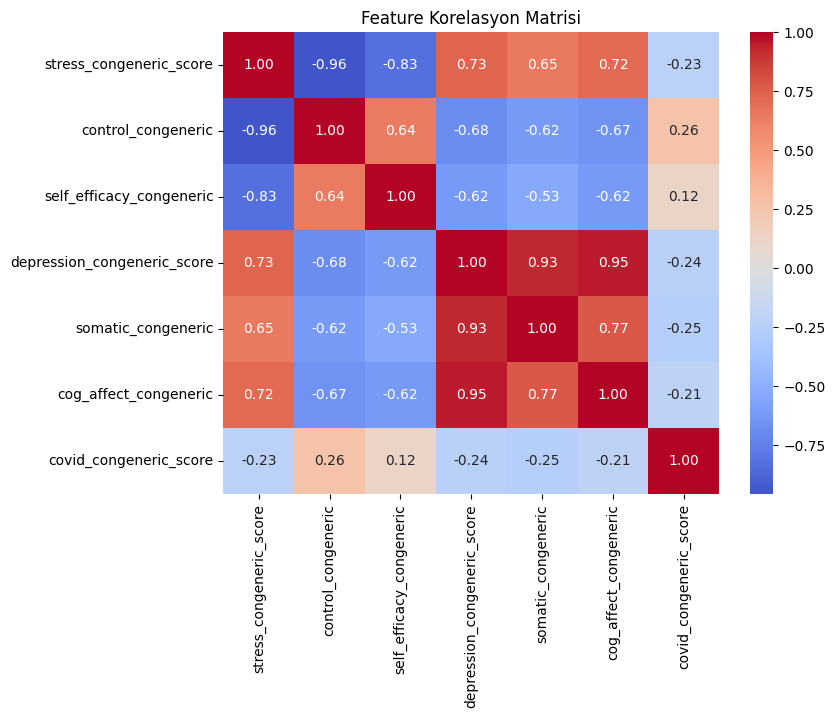

In [17]:
# target oluşturmak için feature'ların kendi aralarındaki ilişkileri incelemek ve efa için yol hazırlamak 

import seaborn as sns
import matplotlib.pyplot as plt

corr = df_reduced[[
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric",
    "covid_congeneric_score"
]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Korelasyon Matrisi")
plt.show()


covidin pek etkili bir değer olmadığı görülüyor, değerler arasına eklenmeyebilir. 

In [8]:
features_with_covid = [
    "stress_congeneric_score", "control_congeneric", "self_efficacy_congeneric",
    "depression_congeneric_score", "somatic_congeneric", "cog_affect_congeneric",
    "covid_congeneric_score"
]

features_without_covid = [
    "stress_congeneric_score", "control_congeneric", "self_efficacy_congeneric",
    "depression_congeneric_score", "somatic_congeneric", "cog_affect_congeneric"
]

corr_with_covid = df_reduced[features_with_covid].corr()
corr_without_covid = df_reduced[features_without_covid].corr()

import numpy as np
mean_with = np.mean(np.abs(corr_with_covid.values[np.triu_indices_from(corr_with_covid, k=1)]))
mean_without = np.mean(np.abs(corr_without_covid.values[np.triu_indices_from(corr_without_covid, k=1)]))

print("Covid dahil ortalama korelasyon:", round(mean_with, 3))
print("Covid hariç ortalama korelasyon:", round(mean_without, 3))


Covid dahil ortalama korelasyon: 0.582
Covid hariç ortalama korelasyon: 0.727


In [19]:
# feature'lar arası sayısal korelasyon- EFA anlamlı sonuç verir mi? 
import numpy as np
mean_corr = np.mean(np.abs(corr.values[np.triu_indices_from(corr, k=1)]))
print("Ortalama mutlak korelasyon:", round(mean_corr, 3))


Ortalama mutlak korelasyon: 0.582


In [20]:
df_reduced = pd.read_csv("merge_all_factor_427.csv")

# =========================================
# 2. Yönsel düzeltme
# =========================================
negatives = [
    "stress_congeneric_score",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric"
]

for col in negatives:
    df_reduced[col] *= -1


--Özelliklerin Yönsel Tutarlılığının Sağlanması
Modelleme aşamasında (özellikle faktör analizi veya PCA gibi boyut indirgeme yöntemleri öncesinde),
değişkenlerin aynı kavramsal yönü temsil etmesi gerekir.
Bu çalışmada “yüksek skor”un, yüksek öğrenme potansiyelini ifade etmesi amaçlanmıştır.
Ancak bazı değişkenler doğası gereği öğrenmeyi negatif etkiler (örneğin stres, depresyon).
Bu nedenle bu değişkenlerin yönleri ters çevrilmiştir (*=-1),
böylece tüm skorlar aynı yönde anlam kazanmıştır:
yüksek skor → yüksek öğrenme kapasitesi.

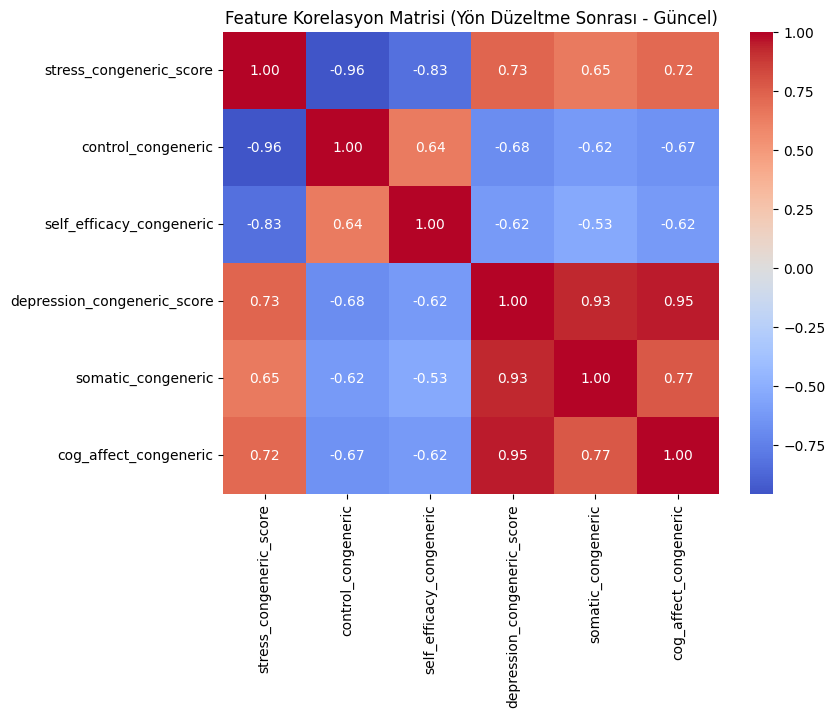

In [ ]:

#import pandas as pd

#negatives = [
 #   "stress_congeneric_score",
 #   "depression_congeneric_score",
 #   "somatic_congeneric",
 #   "cog_affect_congeneric"
]

#for col in negatives:
    df_reduced[col] *= -1

# ==============================================================
# 3. Yeni korelasyon matrisi (güncel veriden)
# ==============================================================
#import seaborn as sns
#import matplotlib.pyplot as plt

#corr_new = df_reduced[[
 #   "stress_congeneric_score",
  #  "control_congeneric",
   # "self_efficacy_congeneric",
    #"depression_congeneric_score",
    #"somatic_congeneric",
    #"cog_affect_congeneric"
#]].corr()

#plt.figure(figsize=(8,6))
#sns.heatmap(corr_new, annot=True, cmap="coolwarm", center=0, fmt=".2f")
#plt.title("Feature Korelasyon Matrisi (Yön Düzeltme Sonrası - Güncel)")
#plt.show()


feature'ların EFA için uyumlu olup olmadığını anlamak adına yapılması gereken testler: KMO ve Bartlett

In [9]:
!python3 -m pip install factor_analyzer


In [69]:
from factor_analyzer.factor_analyzer import calculate_kmo

efa_features = [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
     "cog_affect_congeneric"
]
kmo_all, kmo_model = calculate_kmo(df_reduced[efa_features])
print("KMO (genel):", round(kmo_model, 3))

KMO (genel): 0.579


KMO sonucu beklenen seviyede değil, EFA için yetersiz. 

In [70]:
kmo_all, kmo_model = calculate_kmo(df_reduced[efa_features])
kmo_all  # her değişkenin bireysel KMO'su


array([0.60657537, 0.56965143, 0.52154768, 0.61124005, 0.56200343,
       0.5896046 ])

KMO için uygun olmadıklarını gözlemledik, şimdi de PCA için deneme yapacağız 

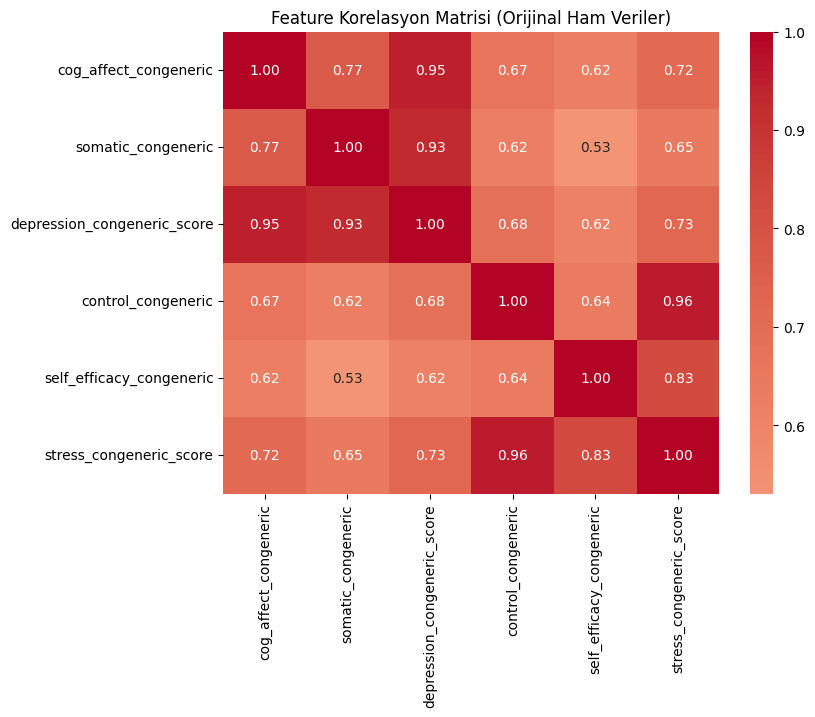

In [71]:
original_cols = [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric"
]

df_check = pd.read_csv("merge_all_factor_427.csv", usecols=original_cols)
corr_raw = df_check.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_raw, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Feature Korelasyon Matrisi (Orijinal Ham Veriler)")
plt.show()


In [57]:
# 🔧 Yönsel düzeltmeyi koşullu hale getiriyoruz (kalıcı çözüm)

#reverse_cols = ["stress_congeneric_score",
                 #"depression_congeneric_score",
                 #"somatic_congeneric",
                 #"cog_affect_congeneric"]

#for col in reverse_cols:
   # mean_val = df_reduced[col].mean()
   # if mean_val > 0:  # pozitifse, ters çevir
     #   df_reduced[col] = -df_reduced[col]
    #    print(f"{col} yönü düzeltildi (ortalama {round(mean_val,3)})")
  #  else:
  #      print(f"{col} zaten doğru yönlü (ortalama {round(mean_val,3)})")

#print("\nYönsel düzeltme tamamlandı ✅")
df_reduced.describe().T[['mean','std']].round(3)



,mean,std
pos_state_anxiety_congeneric,0.000,1.035
neg_state_anxiety_congeneric,-0.000,1.041
pos_trait_anxiety_congeneric,0.000,1.046
neg_trait_anxiety_congeneric,0.000,1.049
pos_state_anxiety_parallel,-0.000,0.748
...,...,...
badly_quart_congeneric,2.496,1.118
depression_quart_congeneric,2.496,1.118
cog_affect_quart_congeneric,2.496,1.118
somatic_quart_congeneric,2.496,1.118


In [74]:
# pca öncesi sütunların doğru yönde olup olmadığını kontrol etmeliyiz 
df_reduced[[
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric"
]].head(5)


,stress_congeneric_score,control_congeneric,self_efficacy_congeneric,depression_congeneric_score,somatic_congeneric,cog_affect_congeneric
0,0.994499,-0.568381,-1.568341,0.852725,1.522905,0.294627
1,1.601830,-1.258011,-1.846971,1.430514,1.403349,1.390766
2,-0.183967,0.516081,-0.397377,0.347319,-0.019725,0.594503
3,-0.419527,0.581236,0.063644,0.825759,1.003940,0.594503
4,1.093718,-1.413048,-0.214986,-0.870991,-1.372580,-0.501635


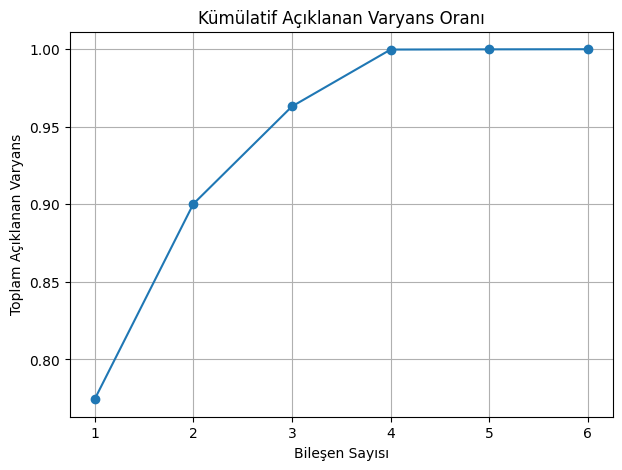

Açıklanan varyans oranları: [np.float64(0.774), np.float64(0.126), np.float64(0.063), np.float64(0.037), np.float64(0.0), np.float64(0.0)]


In [76]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler 

pca_features = [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric"
]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_reduced[pca_features])

pca = PCA()
pca.fit(scaled_data)

explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(7,5))
plt.plot(range(1, len(explained_variance) +1), explained_variance.cumsum(), marker='o')
plt.title("Kümülatif Açıklanan Varyans Oranı")
plt.xlabel("Bileşen Sayısı")
plt.ylabel("Toplam Açıklanan Varyans")
plt.grid(True)
plt.show()

print("Açıklanan varyans oranları:", [round(v, 3) for v in explained_variance])

In [77]:
import numpy as np
print("Kümülatif varyans:", np.cumsum(explained_variance))
#pca uygun bir seçenek 

Kümülatif varyans: [0.77434729 0.90024388 0.96311592 0.99978556 0.99992059 1.        ]


In [79]:
pca = PCA(n_components=1)
pc1 = pca.fit_transform(scaled_data)
df_reduced["learning_potential_score"] = pc1

df_reduced["learning_potential_score"].describe()

count    4.270000e+02
mean     4.160086e-17
std      2.158006e+00
min     -5.947306e+00
25%     -1.495320e+00
50%     -1.874215e-02
75%      1.748461e+00
max      4.279605e+00
Name: learning_potential_score, dtype: float64

In [80]:
pca.components_[0]


array([ 0.42821666, -0.40175316, -0.36930665,  0.43294883,  0.39666971,
        0.41718813])

In [ ]:
#df_reduced.info()
final_cols = [
    "stress_congeneric_score",
    "control_congeneric",
    "self_efficacy_congeneric",
    "depression_congeneric_score",
    "somatic_congeneric",
    "cog_affect_congeneric",
    "learning_potential_score"
]
df_final = df_reduced[final_cols]
#df_final.to_csv("final_learning_potential_dataset.csv", index=False)
df_final 


,stress_congeneric_score,control_congeneric,self_efficacy_congeneric,depression_congeneric_score,somatic_congeneric,cog_affect_congeneric,learning_potential_score
0,0.994499,-0.568381,-1.568341,0.852725,1.522905,0.294627,2.153331
1,1.601830,-1.258011,-1.846971,1.430514,1.403349,1.390766,3.369578
2,-0.183967,0.516081,-0.397377,0.347319,-0.019725,0.594503,0.234547
3,-0.419527,0.581236,0.063644,0.825759,1.003940,0.594503,0.534051
4,1.093718,-1.413048,-0.214986,-0.870991,-1.372580,-0.501635,-0.020603
...,...,...,...,...,...,...,...
422,-0.526346,0.771696,-0.245446,-0.040787,-0.047861,-0.005249,-0.453510
423,0.678578,-0.629416,-0.584246,0.280819,0.284133,0.219479,1.005631
424,0.665961,-1.056399,0.159883,0.092050,0.186550,-0.052179,0.693036
425,-1.113904,0.781303,1.639937,-0.892721,-1.781275,-0.094988,-2.336883
